In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, average_precision_score


import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = '../data/einkommen.train'

data = []

with open(file_path, 'r') as file:
  for line in file:
    data.append(line.strip().split(','))

columns = ['Age', 'Employment_Type', 'Weighting', 'Education', 'Schooling_Training', 'Marital_Status', 'Employment_Area',
           'Partnership', 'Ethnicity', 'Gender', 'Financial_Assets_Gains', 'Financial_Assets_Loses', 'Weekly_Working_Time', 'Country_Of_Birth', 'Income' ]

df = pd.DataFrame(data, columns = columns)

In [3]:
df.head()

,Age,Employment_Type,Weighting,Education,Schooling_Training,Marital_Status,Employment_Area,Partnership,Ethnicity,Gender,Financial_Assets_Gains,Financial_Assets_Loses,Weekly_Working_Time,Country_Of_Birth,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
df.drop(columns=["Unnamed: 0"], errors="ignore", axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     30000 non-null  object
 1   Employment_Type         30000 non-null  object
 2   Weighting               30000 non-null  object
 3   Education               30000 non-null  object
 4   Schooling_Training      30000 non-null  object
 5   Marital_Status          30000 non-null  object
 6   Employment_Area         30000 non-null  object
 7   Partnership             30000 non-null  object
 8   Ethnicity               30000 non-null  object
 9   Gender                  30000 non-null  object
 10  Financial_Assets_Gains  30000 non-null  object
 11  Financial_Assets_Loses  30000 non-null  object
 12  Weekly_Working_Time     30000 non-null  object
 13  Country_Of_Birth        30000 non-null  object
 14  Income                  30000 non-null  object
dtypes:

In [6]:
df.describe().T

,count,unique,top,freq
Age,30000,72,36,824
Employment_Type,30000,9,Private,20901
Weighting,30000,20433,123011,13
Education,30000,16,HS-grad,9692
Schooling_Training,30000,16,9,9692
Marital_Status,30000,7,Married-civ-spouse,13768
Employment_Area,30000,15,Prof-specialty,3802
Partnership,30000,6,Husband,12138
Ethnicity,30000,5,White,25636
Gender,30000,2,Male,20070


In [7]:
df.isna().sum()

Age                       0
Employment_Type           0
Weighting                 0
Education                 0
Schooling_Training        0
Marital_Status            0
Employment_Area           0
Partnership               0
Ethnicity                 0
Gender                    0
Financial_Assets_Gains    0
Financial_Assets_Loses    0
Weekly_Working_Time       0
Country_Of_Birth          0
Income                    0
dtype: int64

In [8]:
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [9]:
df = df.replace('?', np.nan)

In [10]:
df.isna().sum()

Age                           0
Employment_Type            1677
Weighting                     0
Education                     0
Schooling_Training            0
Marital_Status                0
Employment_Area            1682
Partnership                   0
Ethnicity                     0
Gender                        0
Financial_Assets_Gains        0
Financial_Assets_Loses        0
Weekly_Working_Time           0
Country_Of_Birth            539
Income                    25000
dtype: int64

In [11]:
df['Income'] = df['Income'].map({'<=50K': 0, '>50K': 1})

In [12]:
num_cols = ['Age','Weighting', 'Financial_Assets_Gains','Financial_Assets_Loses','Weekly_Working_Time']
cat_cols = df.drop(['Age','Weighting','Financial_Assets_Gains','Financial_Assets_Loses','Weekly_Working_Time', 'Income', 'Country_Of_Birth'], axis=1).columns.tolist()

In [13]:
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

In [14]:
df_labeled = df[df["Income"].notna()].copy()
df_unlabeled = df[df["Income"].isna()].copy()

In [15]:
df_labeled['Income'] = df_labeled['Income'].astype(int)

In [16]:
df_labeled.to_csv('../data/train.csv')
df_unlabeled.to_csv('../data/test.csv')

## EDA

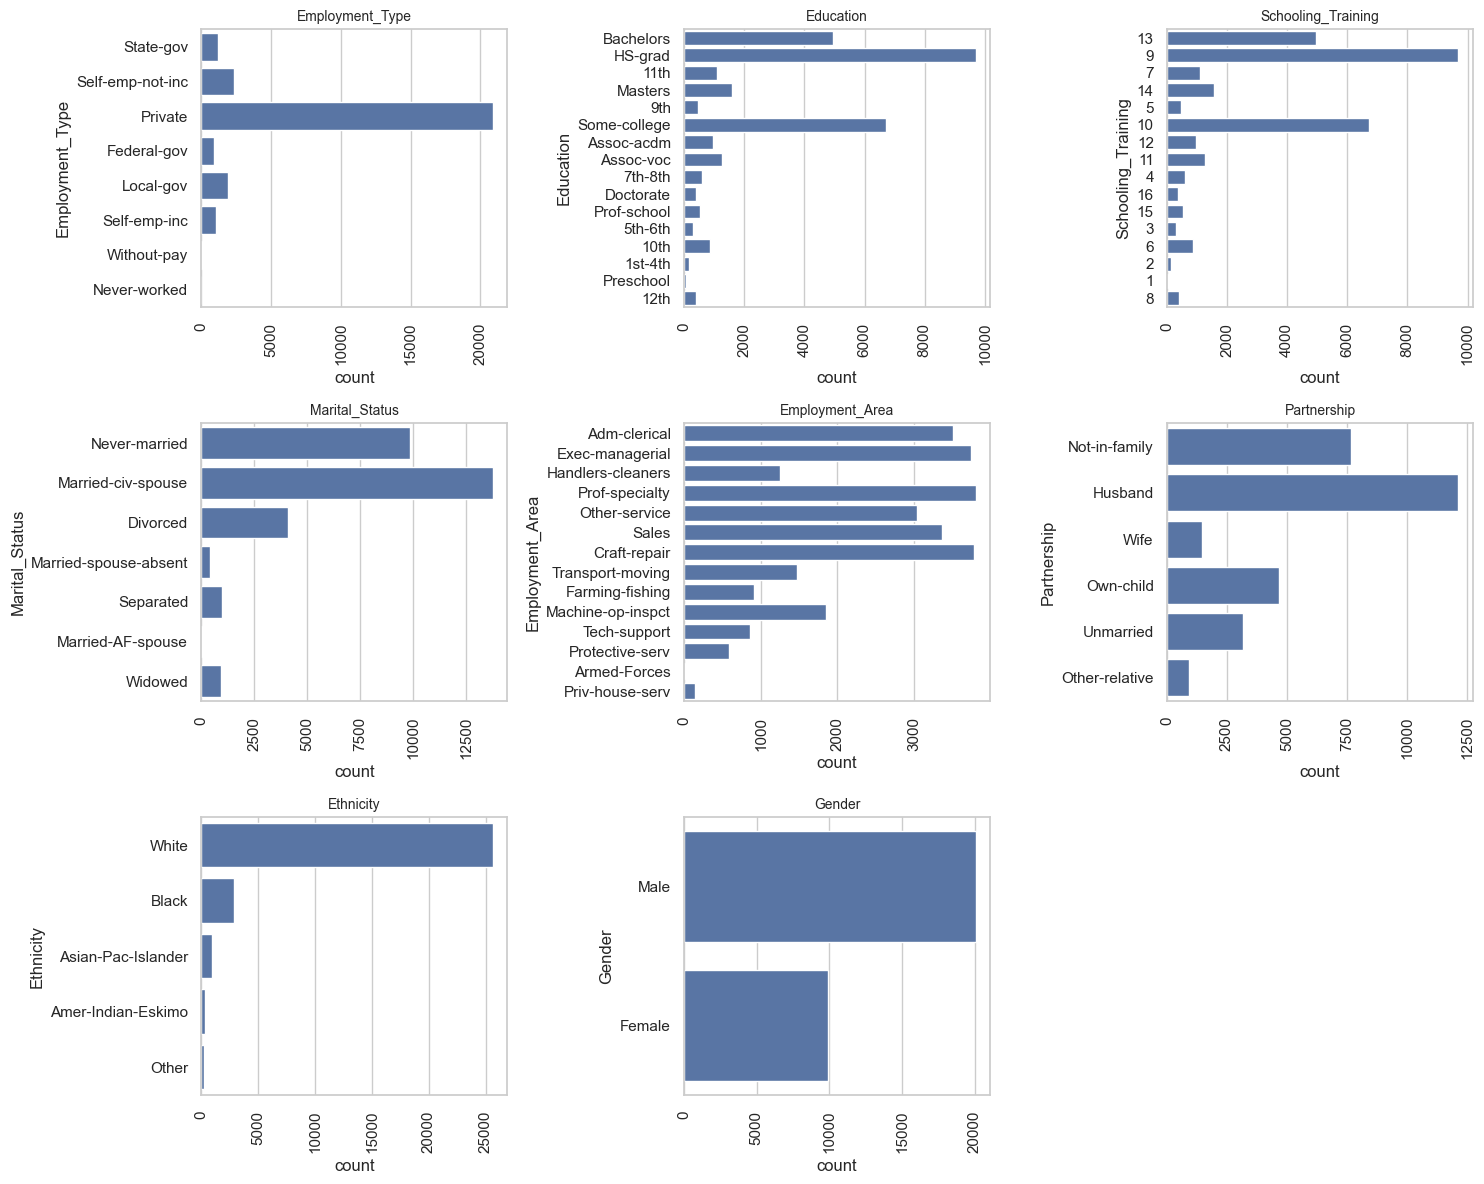

In [17]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=df, y=col, ax=ax)
    ax.tick_params(axis="x", rotation=90, size=8)
    ax.set_title(f"{col}", fontsize=10)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.savefig('../docs/countplots.png')
plt.show()

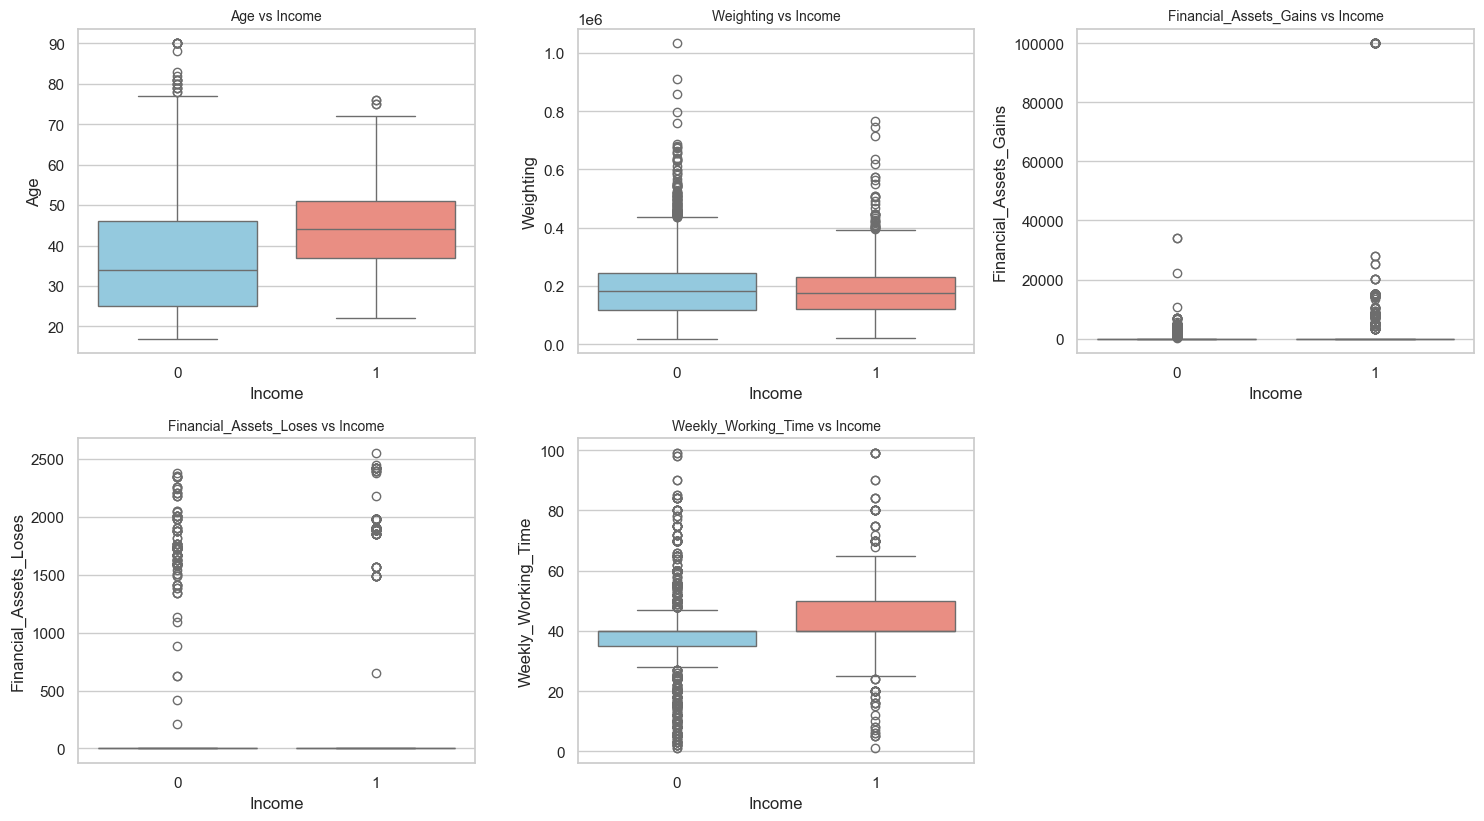

In [18]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    ax = axes[i]
    sns.boxplot(data=df_labeled, x=df_labeled["Income"].astype(str), y=col, ax=ax,
                palette={"0": "skyblue", "1": "salmon"})
    ax.set_title(f"{col} vs Income", fontsize=10)

# Remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("../docs/numplots.png")
plt.show()

<Axes: >

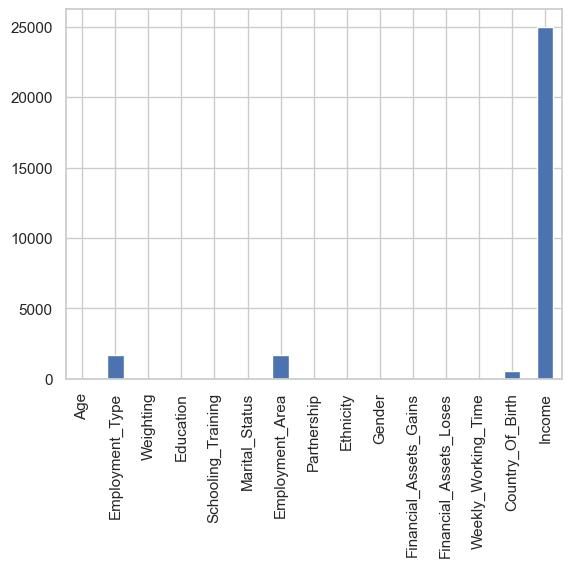

In [19]:
df.isna().sum().plot(kind="bar")

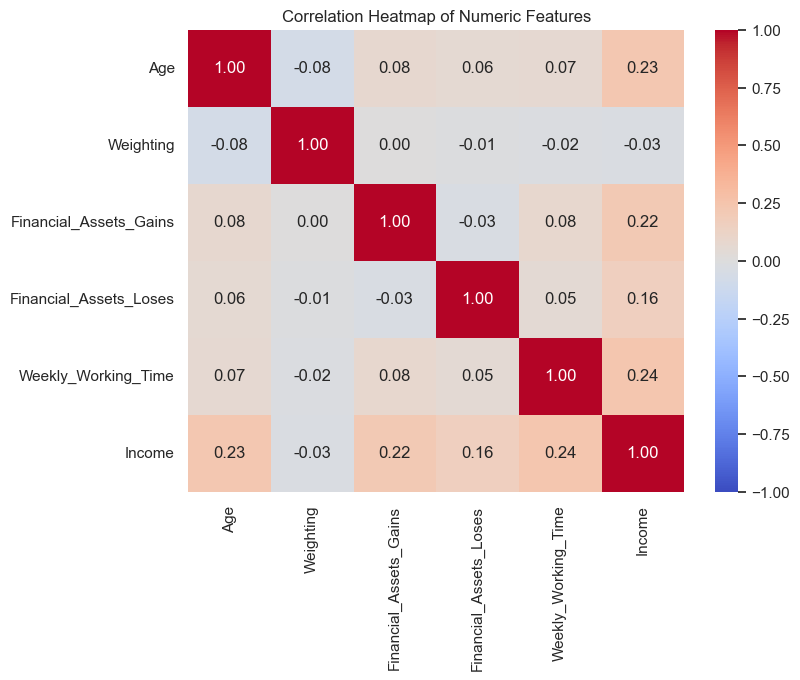

In [20]:
corr = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

## Pre-Processing Pipeline

In [21]:
X = df_labeled.drop(columns=["Income", "Weighting", "Unnamed: 0"], errors="ignore")
y = df_labeled["Income"]
weights = df_labeled["Weighting"]
weights = weights / weights.mean()

In [22]:
# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, stratify=y, random_state=42
)

In [23]:
num_plain = ["Age", "Weekly_Working_Time"]
num_log   = ["Financial_Assets_Gains", "Financial_Assets_Loses"]
ord_cols  = ["Schooling_Training"]
cat_cols  = [c for c in X.columns if c not in num_plain +num_log + ord_cols + ["Weighting"]]

In [24]:
# Pipeline

num_plain_tf = Pipeline([
    ("scaler", StandardScaler())
])

num_log_tf = Pipeline([
    ("log1p", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())
])

ord_tf = Pipeline([
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

cat_tf = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num_plain", num_plain_tf, num_plain),
    ("num_log", num_log_tf, num_log),
    ("ord", ord_tf, ord_cols),
    ("cat", cat_tf, cat_cols)
])

## Logistic Regression (Baseline Model)

In [25]:
logreg = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

logreg.fit(X_train, y_train, model__sample_weight=w_train)
y_pred_lr = logreg.predict(X_test)
y_prob_lr = logreg.predict_proba(X_test)[:, 1]

print("=== Logistic Regression (baseline) ===")
print(classification_report(y_test, y_pred_lr, sample_weight=w_test))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr, sample_weight=w_test))
print("PR-AUC:", average_precision_score(y_test, y_prob_lr, sample_weight=w_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr, sample_weight=w_test))

=== Logistic Regression (baseline) ===
              precision    recall  f1-score   support

           0       0.89      0.94      0.91 779.16027905649
           1       0.75      0.59      0.66 233.89814683091208

    accuracy                           0.86 1013.0584258874021
   macro avg       0.82      0.77      0.79 1013.0584258874021
weighted avg       0.85      0.86      0.86 1013.0584258874021

ROC-AUC: 0.9147229745584945
PR-AUC: 0.7797664528295801
Confusion Matrix:
 [[733.55151971  45.60875934]
 [ 94.80723796 139.09090887]]


## Logistic Reg (Holdout testing and CV comparison)

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, average_precision_score

# === 3. Logistic Regression (with weights) ===
logreg = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

# Fit on training data
logreg.fit(X_train, y_train, model__sample_weight=w_train)

# --- Holdout evaluation ---
y_pred_lr = logreg.predict(X_test)
y_prob_lr = logreg.predict_proba(X_test)[:, 1]

print("=== Logistic Regression (weighted, Holdout) ===")
print(classification_report(y_test, y_pred_lr, sample_weight=w_test))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr, sample_weight=w_test))
print("PR-AUC:", average_precision_score(y_test, y_prob_lr, sample_weight=w_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr, sample_weight=w_test))

# --- Cross-validation evaluation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision"
}

cv_results_lr = cross_validate(
    logreg,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    params={"model__sample_weight": w_train.to_numpy()}
)


print("\n\n=== Logistic Regression (weighted, Cross Validation) ===")
print("ROC-AUC: %.3f ± %.3f" % (
    cv_results_lr["test_roc_auc"].mean(),
    cv_results_lr["test_roc_auc"].std()
))
print("PR-AUC : %.3f ± %.3f" % (
    cv_results_lr["test_pr_auc"].mean(),
    cv_results_lr["test_pr_auc"].std()
))


=== Logistic Regression (weighted, Holdout) ===
              precision    recall  f1-score   support

           0       0.89      0.94      0.91 779.16027905649
           1       0.75      0.59      0.66 233.89814683091208

    accuracy                           0.86 1013.0584258874021
   macro avg       0.82      0.77      0.79 1013.0584258874021
weighted avg       0.85      0.86      0.86 1013.0584258874021

ROC-AUC: 0.9147229745584945
PR-AUC: 0.7797664528295801
Confusion Matrix:
 [[733.55151971  45.60875934]
 [ 94.80723796 139.09090887]]


=== Logistic Regression (weighted, Cross Validation) ===
ROC-AUC: 0.893 ± 0.010
PR-AUC : 0.725 ± 0.027


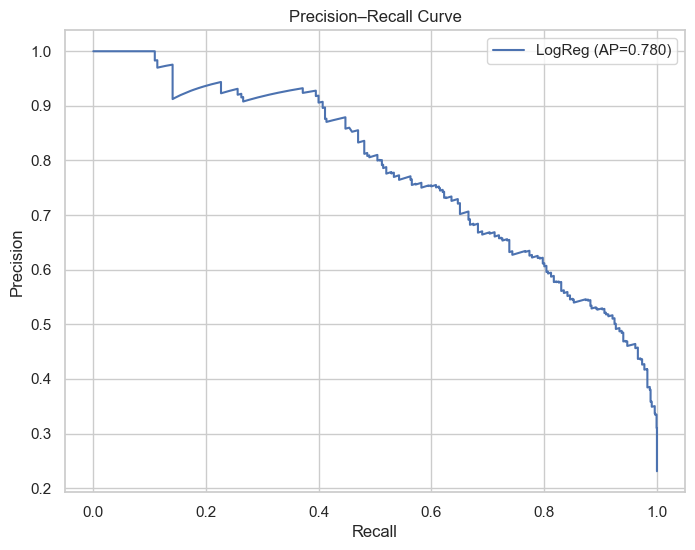

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# === Precision–Recall curve for Logistic Regression ===
prec, rec, thres = precision_recall_curve(y_test, y_prob_lr, sample_weight=w_test)
ap = average_precision_score(y_test, y_prob_lr, sample_weight=w_test)

plt.figure(figsize=(8,6))
plt.plot(rec, prec, label=f"LogReg (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# --- Find threshold for high precision (e.g., ≥90%) ---
# target_precision = 0.9
# idx = np.argmax(prec >= target_precision)

# if idx < len(thres):   # check threshold array not exhausted
#     chosen_threshold = thres[idx]
#     print(f"Threshold for ~{target_precision*100:.0f}% precision: {chosen_threshold:.3f}")
#     print(f"Precision: {prec[idx]:.3f}, Recall: {rec[idx]:.3f}")
# else:
#     print("Could not reach desired precision level in this model.")


## Decision Trees

In [28]:
dt_default = Pipeline([
    ("prep", preprocessor),   # same preprocessing as before
    ("model", DecisionTreeClassifier(random_state=42))
])

# Fit with weights
dt_default.fit(X_train, y_train, model__sample_weight=w_train)

# Predictions
y_pred_dt = dt_default.predict(X_test)
y_prob_dt = dt_default.predict_proba(X_test)[:, 1]

# Evaluation (weighted)
print("=== Decision Tree (Default Parameters, Holdout) ===")
print(classification_report(y_test, y_pred_dt, sample_weight=w_test))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_dt, sample_weight=w_test))
print("PR-AUC:", average_precision_score(y_test, y_prob_dt, sample_weight=w_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt, sample_weight=w_test))

=== Decision Tree (Default Parameters, Holdout) ===
              precision    recall  f1-score   support

           0       0.87      0.85      0.86 779.16027905649
           1       0.54      0.59      0.57 233.89814683091208

    accuracy                           0.79 1013.0584258874021
   macro avg       0.71      0.72      0.71 1013.0584258874021
weighted avg       0.80      0.79      0.79 1013.0584258874021

ROC-AUC: 0.7251819733592082
PR-AUC: 0.4180052008400996
Confusion Matrix:
 [[662.04014219 117.12013686]
 [ 95.07942665 138.81872018]]


## Hypertuning the Decision Tree (Pre-pruning)

In [38]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score

# Define scorers
scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision"
}

# Stratified CV so each fold has both classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Decision Tree pipeline
dt = Pipeline([
    ("prep", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

# Parameter grid
param_grid = {
    "model__max_depth": [3, 5, 10, 15,None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 5, 10]
}

# GridSearchCV
grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit="roc_auc",   # refit the best model according to ROC-AUC
    n_jobs=-1
)

# Fit with sample weights
grid_dt.fit(X_train, y_train, model__sample_weight=w_train.to_numpy())

# CV Results
print("\n=== Decision Tree CV Results ===")
print("Best Params:", grid_dt.best_params_)
print("Best CV ROC-AUC:", grid_dt.cv_results_['mean_test_roc_auc'][grid_dt.best_index_])
print("Best CV PR-AUC :", grid_dt.cv_results_['mean_test_pr_auc'][grid_dt.best_index_])

# Holdout evaluation with best model
best_dt = grid_dt.best_estimator_

y_pred_dt = best_dt.predict(X_test)
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]

print("\n=== Decision Tree (Tuned, Holdout) ===")
print(classification_report(y_test, y_pred_dt, sample_weight=w_test))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_dt, sample_weight=w_test))
print("PR-AUC:", average_precision_score(y_test, y_prob_dt, sample_weight=w_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt, sample_weight=w_test))



=== Decision Tree CV Results ===
Best Params: {'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}
Best CV ROC-AUC: 0.8748618618559274
Best CV PR-AUC : 0.7185056479434162

=== Decision Tree (Tuned, Holdout) ===
              precision    recall  f1-score   support

           0       0.90      0.90      0.90 779.16027905649
           1       0.66      0.65      0.66 233.89814683091208

    accuracy                           0.84 1013.0584258874021
   macro avg       0.78      0.78      0.78 1013.0584258874021
weighted avg       0.84      0.84      0.84 1013.0584258874021

ROC-AUC: 0.8764678666649923
PR-AUC: 0.735934147682406
Confusion Matrix:
 [[701.88436713  77.27591193]
 [ 80.86203523 153.0361116 ]]


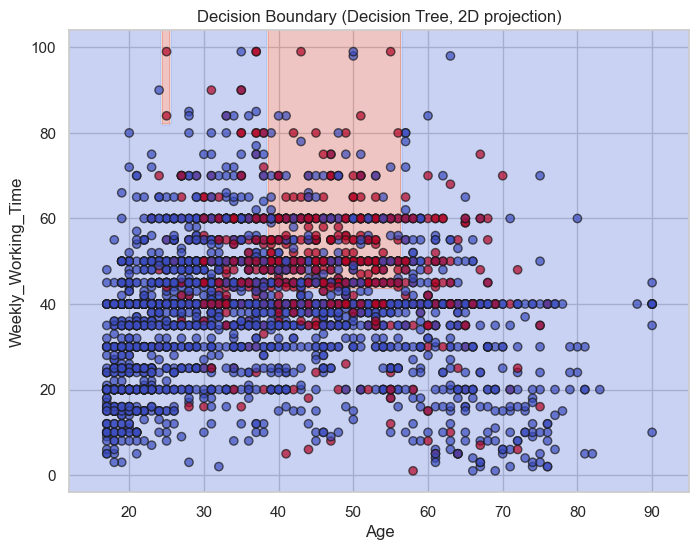

In [30]:
feat_x = "Age"
feat_y = "Weekly_Working_Time"

# Subset data
X_2d = df_labeled[[feat_x, feat_y]]
y_2d = df_labeled["Income"].astype(int)

# Train a simple decision tree on just 2 features
dt_2d = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_2d.fit(X_2d, y_2d)

# Create grid for plotting decision surface
x_min, x_max = X_2d[feat_x].min()-5, X_2d[feat_x].max()+5
y_min, y_max = X_2d[feat_y].min()-5, X_2d[feat_y].max()+5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = dt_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
plt.scatter(X_2d[feat_x], X_2d[feat_y], c=y_2d, cmap="coolwarm", edgecolor="k", alpha=0.7)
plt.xlabel(feat_x)
plt.ylabel(feat_y)
plt.title("Decision Boundary (Decision Tree, 2D projection)")
plt.show()

## Decision Tree (without pre-processing)

In [43]:
num_cols_tree = ["Age", "Financial_Assets_Gains", "Financial_Assets_Loses", "Weekly_Working_Time"]
ord_cols_tree = ["Schooling_Training"]
cat_cols_tree = [c for c in X.columns if c not in num_cols_tree + ord_cols_tree + ["Weighting"]]

# Preprocessor for tree
tree_preprocessor = ColumnTransformer([
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ord_cols_tree),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_tree)
], remainder="passthrough")  # passthrough numeric columns unchanged

# Decision Tree pipeline
dt_tree = Pipeline([
    ("prep", tree_preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

# === Fit and evaluate with default params ===
dt_tree.fit(X_train, y_train, model__sample_weight=w_train)

y_pred_dt = dt_tree.predict(X_test)
y_prob_dt = dt_tree.predict_proba(X_test)[:, 1]

print("=== Decision Tree (Tree-Specific Preprocessing, Default) ===")
print(classification_report(y_test, y_pred_dt, sample_weight=w_test))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_dt, sample_weight=w_test))
print("PR-AUC:", average_precision_score(y_test, y_prob_dt, sample_weight=w_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt, sample_weight=w_test))

=== Decision Tree (Tree-Specific Preprocessing, Default) ===
              precision    recall  f1-score   support

           0       0.88      0.85      0.86 779.16027905649
           1       0.55      0.60      0.57 233.89814683091208

    accuracy                           0.79 1013.0584258874021
   macro avg       0.71      0.73      0.72 1013.0584258874021
weighted avg       0.80      0.79      0.80 1013.0584258874021

ROC-AUC: 0.7301832218940791
PR-AUC: 0.42291845685260204
Confusion Matrix:
 [[662.34042254 116.81985652]
 [ 92.64328942 141.25485741]]


## Random Forest (Ensemble) (without pre-processing)

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Columns for RF preprocessing
num_cols_rf = ["Age", "Financial_Assets_Gains", "Financial_Assets_Loses", "Weekly_Working_Time"]
ord_cols_rf = ["Schooling_Training"]
cat_cols_rf = [c for c in X.columns if c not in num_cols_rf + ord_cols_rf + ["Weighting"]]

# Preprocessor for Random Forest
rf_preprocessor = ColumnTransformer([
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ord_cols_rf),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_rf)
], remainder="passthrough")  # passthrough raw numeric columns

# Random Forest pipeline
rf = Pipeline([
    ("prep", rf_preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit with weights
rf.fit(X_train, y_train, model__sample_weight=w_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("=== Random Forest (Tree-Specific Preprocessing, Holdout) ===")
print(classification_report(y_test, y_pred_rf, sample_weight=w_test))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf, sample_weight=w_test))
print("PR-AUC:", average_precision_score(y_test, y_prob_rf, sample_weight=w_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf, sample_weight=w_test))


=== Random Forest (Tree-Specific Preprocessing, Holdout) ===
              precision    recall  f1-score   support

           0       0.88      0.91      0.89 779.16027905649
           1       0.65      0.58      0.62 233.89814683091208

    accuracy                           0.83 1013.0584258874021
   macro avg       0.77      0.75      0.75 1013.0584258874021
weighted avg       0.83      0.83      0.83 1013.0584258874021

ROC-AUC: 0.8964783940009592
PR-AUC: 0.7121538931806369
Confusion Matrix:
 [[707.36135915  71.7989199 ]
 [ 97.70268083 136.195466  ]]


## Random Forest (with pre-processing)

In [33]:
num_plain = ["Age", "Weekly_Working_Time"]
num_log   = ["Financial_Assets_Gains", "Financial_Assets_Loses"]
ord_cols  = ["Schooling_Training"]
cat_cols  = [c for c in X.columns if c not in num_plain + num_log + ord_cols + ["Weighting"]]

# Transformers
num_plain_tf = Pipeline([
    ("scaler", StandardScaler())
])

num_log_tf = Pipeline([
    ("log1p", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())
])

ord_tf = Pipeline([
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

cat_tf = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocessor
rf_preprocessor_full = ColumnTransformer([
    ("num_plain", num_plain_tf, num_plain),
    ("num_log", num_log_tf, num_log),
    ("ord", ord_tf, ord_cols),
    ("cat", cat_tf, cat_cols)
])

# Random Forest pipeline with preprocessing
rf_full = Pipeline([
    ("prep", rf_preprocessor_full),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit with weights
rf_full.fit(X_train, y_train, model__sample_weight=w_train)

# Predictions
y_pred_rf_full = rf_full.predict(X_test)
y_prob_rf_full = rf_full.predict_proba(X_test)[:, 1]

# Evaluation
print("=== Random Forest (Full Preprocessing with Log Transform, Holdout) ===")
print(classification_report(y_test, y_pred_rf_full, sample_weight=w_test))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf_full, sample_weight=w_test))
print("PR-AUC:", average_precision_score(y_test, y_prob_rf_full, sample_weight=w_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_full, sample_weight=w_test))

=== Random Forest (Full Preprocessing with Log Transform, Holdout) ===
              precision    recall  f1-score   support

           0       0.88      0.91      0.89 779.16027905649
           1       0.64      0.57      0.61 233.89814683091208

    accuracy                           0.83 1013.0584258874021
   macro avg       0.76      0.74      0.75 1013.0584258874021
weighted avg       0.82      0.83      0.82 1013.0584258874021

ROC-AUC: 0.8918801426180473
PR-AUC: 0.7005290140915963
Confusion Matrix:
 [[705.56340938  73.59686968]
 [100.23968383 133.658463  ]]


## Random Forest Hypertuning

In [35]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest pipeline (with full preprocessing)
rf_tuned = Pipeline([
    ("prep", rf_preprocessor_full),   # from earlier: includes log + scaling + OHE
    ("model", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Hyperparameter grid
param_grid_rf = {
    "model__n_estimators": [100, 200],       # number of trees
    "model__max_depth": [None, 10, 20],      # limit depth
    "model__min_samples_split": [2, 5],      # min samples to split
    "model__min_samples_leaf": [1, 5]        # min samples per leaf
}

# GridSearchCV
grid_rf = GridSearchCV(
    estimator=rf_tuned,
    param_grid=param_grid_rf,
    cv=cv,
    scoring={"roc_auc": "roc_auc", "pr_auc": "average_precision"},
    refit="roc_auc",   # refit best model according to ROC-AUC
    n_jobs=-1,
    verbose=2
)

# Fit with sample weights
grid_rf.fit(X_train, y_train, model__sample_weight=w_train.to_numpy())

# Best params and CV scores
print("\n=== Random Forest CV Results ===")
print("Best Params:", grid_rf.best_params_)
print("Best CV ROC-AUC:", grid_rf.cv_results_['mean_test_roc_auc'][grid_rf.best_index_])
print("Best CV PR-AUC :", grid_rf.cv_results_['mean_test_pr_auc'][grid_rf.best_index_])

# Evaluate on holdout set
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest (Tuned, Holdout) ===")
print(classification_report(y_test, y_pred_rf, sample_weight=w_test))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf, sample_weight=w_test))
print("PR-AUC:", average_precision_score(y_test, y_prob_rf, sample_weight=w_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf, sample_weight=w_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== Random Forest CV Results ===
Best Params: {'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best CV ROC-AUC: 0.908124491051794
Best CV PR-AUC : 0.7769968856615911

=== Random Forest (Tuned, Holdout) ===
              precision    recall  f1-score   support

           0       0.87      0.97      0.92 779.16027905649
           1       0.84      0.54      0.65 233.89814683091208

    accuracy                           0.87 1013.0584258874021
   macro avg       0.86      0.75      0.79 1013.0584258874021
weighted avg       0.87      0.87      0.86 1013.0584258874021

ROC-AUC: 0.9208871757608651
PR-AUC: 0.7960153838607614
Confusion Matrix:
 [[754.54532173  24.61495732]
 [108.57739074 125.32075609]]


In [44]:
# Collect results into a dict
results = []

# Logistic Regression CV
results.append({
    "Model": "Logistic Regression",
    "CV ROC-AUC": f"{cv_results_lr['test_roc_auc'].mean():.3f}",
    "CV PR-AUC": f"{cv_results_lr['test_pr_auc'].mean():.3f}",
    "Holdout ROC-AUC": f"{roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1], sample_weight=w_test):.3f}",
    "Holdout PR-AUC": f"{average_precision_score(y_test, logreg.predict_proba(X_test)[:,1], sample_weight=w_test):.3f}"
})

# Decision Tree CV (from grid search)
results.append({
    "Model": "Decision Tree (Tuned)",
    "CV ROC-AUC": f"{grid_dt.cv_results_['mean_test_roc_auc'][grid_dt.best_index_]:.3f}",
    "CV PR-AUC": f"{grid_dt.cv_results_['mean_test_pr_auc'][grid_dt.best_index_]:.3f}",
    "Holdout ROC-AUC": f"{roc_auc_score(y_test, grid_dt.best_estimator_.predict_proba(X_test)[:,1], sample_weight=w_test):.3f}",
    "Holdout PR-AUC": f"{average_precision_score(y_test, grid_dt.best_estimator_.predict_proba(X_test)[:,1], sample_weight=w_test):.3f}"
})

# Random Forest CV (from grid search)
results.append({
    "Model": "Random Forest (Tuned)",
    "CV ROC-AUC": f"{grid_rf.cv_results_['mean_test_roc_auc'][grid_rf.best_index_]:.3f}",
    "CV PR-AUC": f"{grid_rf.cv_results_['mean_test_pr_auc'][grid_rf.best_index_]:.3f}",
    "Holdout ROC-AUC": f"{roc_auc_score(y_test, grid_rf.best_estimator_.predict_proba(X_test)[:,1], sample_weight=w_test):.3f}",
    "Holdout PR-AUC": f"{average_precision_score(y_test, grid_rf.best_estimator_.predict_proba(X_test)[:,1], sample_weight=w_test):.3f}"
})

# Make dataframe
df_results = pd.DataFrame(results)

print("\n=== Model Comparison Table ===")
print(df_results.to_string(index=False))



=== Model Comparison Table ===
                Model CV ROC-AUC CV PR-AUC Holdout ROC-AUC Holdout PR-AUC
  Logistic Regression      0.893     0.725           0.915          0.780
Decision Tree (Tuned)      0.875     0.719           0.876          0.736
Random Forest (Tuned)      0.908     0.777           0.921          0.796
